In [2]:
import jax
import jaxlib

print("jax version:", jax.__version__)
print("jaxlib version:", jaxlib.__version__)

import scvi
import h5py
import scanpy as sc
import anndata as ad
import pandas as pd
import scipy.sparse as sp
import numpy as np

jax version: 0.4.35
jaxlib version: 0.4.35


/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRDataset from `anndata.expe

In [2]:


imputed_splicing_estimates = pd.read_hdf("imputed_dfs.h5", key="imputed_splicing_estimates")
imputed_expression_estimates = pd.read_hdf("imputed_dfs.h5", key="imputed_expression_estimates")

                     0         1         2         3         4         5    6  \
cell_id_for_index                                                               
A1_B000826         0.5  0.722544  0.500000  0.500000  0.760712  0.500000  0.5   
A1_B001176         0.5  0.501539  0.500000  0.500000  0.747961  0.500000  0.5   
A1_B003279         0.5  0.647028  0.500000  0.500000  0.857525  0.500000  0.5   
A1_B003281         0.5  0.709940  0.500000  0.500000  0.739297  0.500000  0.5   
A1_B003290         0.5  0.584208  0.531557  0.500000  0.707523  0.500000  0.5   
...                ...       ...       ...       ...       ...       ...  ...   
P9_B003921         0.5  0.847892  0.526712  0.587625  0.651583  0.500899  0.5   
P9_D045315         0.5  0.645976  0.500000  0.500000  0.737857  0.500000  0.5   
P9_D045318         0.5  0.592639  0.500000  0.500000  0.649552  0.500000  0.5   
P9_D045372         0.5  0.553916  0.517337  0.500000  0.930621  0.500000  0.5   
P9_D045853         0.5  0.71

In [10]:

from sklearn.decomposition import PCA
import pandas as pd

# Perform PCA with 1 component
pca = PCA(n_components=1)

# Reduce each dataset to PC1
as_pc1 = pca.fit_transform(imputed_splicing_estimates).flatten()
print(as_pc1.shape)
ge_pc1 = pca.fit_transform(imputed_expression_estimates).flatten()
print(ge_pc1.shape)

# Compute the correlation between PC1 of the two datasets
correlation = np.corrcoef(as_pc1, ge_pc1)[0, 1]
print(f"Correlation between PC1 of splicing and expression: {correlation:.4f}")



(19942,)
(19942,)
Correlation between PC1 of splicing and expression: -0.3159


In [3]:
combined_adata = ad.read_h5ad('/home/sv2785/research_folder/ann_data/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad', backed = "r")
print(combined_adata)


AnnData object with n_obs × n_vars = 19942 × 77042 backed at '/home/sv2785/research_folder/ann_data/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad'
    obs: 'batch_id', 'modality', 'mouse.id', '_indices', '_scvi_batch', '_scvi_labels', 'age', 'sex', 'cell_type_grouped', 'cell_ontology_class'
    var: 'ID', 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'GE_X_umap', 'X_multivi'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix'


In [14]:
import anndata as ad
import pandas as pd
import numpy as np

combined_adata = ad.read_h5ad(
    "/home/sv2785/research_folder/ann_data/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad", backed="r"
)

n_genes = imputed_expression_estimates.shape[1]
n_splicing = imputed_splicing_estimates.shape[1]

gene_expression_corr = []
splicing_corr = []

for i in range(combined_adata.n_obs):
    row = combined_adata[i, :].X.toarray().flatten() if combined_adata.isbacked else combined_adata[i, :].X.flatten()
    row_gene_expression = row[:n_genes]
    row_splicing = row[n_genes:n_genes + n_splicing]
    imputed_gene_expression = imputed_expression_estimates.iloc[i].values
    imputed_splicing = imputed_splicing_estimates.iloc[i].values
    gene_corr = np.corrcoef(row_gene_expression, imputed_gene_expression)[0, 1]
    splicing_corr_value = np.corrcoef(row_splicing, imputed_splicing)[0, 1]
    gene_expression_corr.append(gene_corr)
    splicing_corr.append(splicing_corr_value)

gene_expression_corr = pd.Series(gene_expression_corr, index=combined_adata.obs.index, name="Gene Expression Correlation")
splicing_corr = pd.Series(splicing_corr, index=combined_adata.obs.index, name="Splicing Correlation")


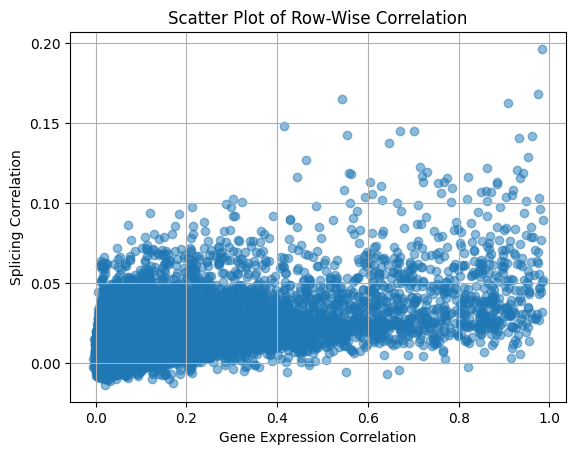

In [15]:
import matplotlib.pyplot as plt

plt.scatter(gene_expression_corr, splicing_corr, alpha=0.5)
plt.title("Scatter Plot of Row-Wise Correlation")
plt.xlabel("Gene Expression Correlation")
plt.ylabel("Splicing Correlation")
plt.grid(True)
plt.show()


In [16]:
print(np.mean(gene_expression_corr))
print(np.mean(splicing_corr))

0.12250414861618902
0.018030958525629113


In [18]:
print(combined_adata.obsm['X_multivi'])

[[-0.38143587 -0.34279865 -0.12188579 ... -0.4010613  -0.215687
  -1.0685703 ]
 [-0.28398383 -0.3798613  -0.08058798 ... -0.90297616 -0.37741438
  -1.0673724 ]
 [-0.37152615 -0.17086738 -0.04803129 ... -0.59711015 -0.23261808
  -0.88624096]
 ...
 [-0.5727163  -0.163072   -0.36292192 ... -0.41638932 -0.03031085
  -1.1944807 ]
 [-0.53255916 -0.32753593 -0.07681026 ... -0.17489715 -0.36156535
   0.08172578]
 [-0.1787365  -0.41945297 -0.04546402 ... -0.790117   -0.32799497
  -1.0947158 ]]


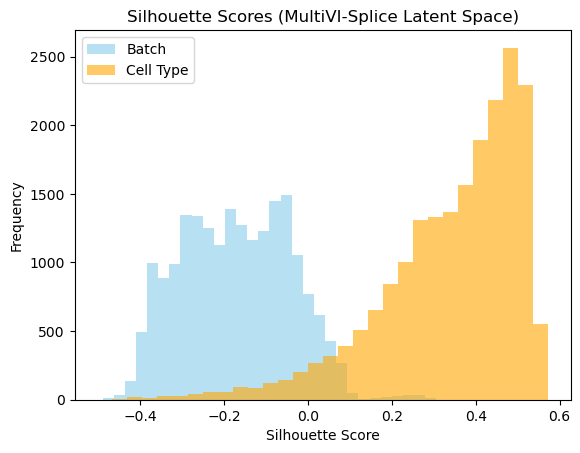

In [13]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd


latent_space = combined_adata.obsm['X_multivi']

# batch silhouette
batch_labels = combined_adata.obs['mouse.id']
batch_silhouette = silhouette_samples(latent_space, batch_labels)

# cell type silhouette
cell_type_labels = combined_adata.obs['cell_type_grouped']
cell_type_silhouette = silhouette_samples(latent_space, cell_type_labels)

silhouette_df = pd.DataFrame({
    'Batch Silhouette': batch_silhouette,
    'Cell Type Silhouette': cell_type_silhouette
}, index=combined_adata.obs.index)

import matplotlib.pyplot as plt

plt.hist(silhouette_df['Batch Silhouette'], bins=30, alpha=0.6, label="Batch", color="skyblue")
plt.hist(silhouette_df['Cell Type Silhouette'], bins=30, alpha=0.6, label="Cell Type", color="orange")
plt.legend()
plt.title("Silhouette Scores (MultiVI-Splice Latent Space)")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.show()


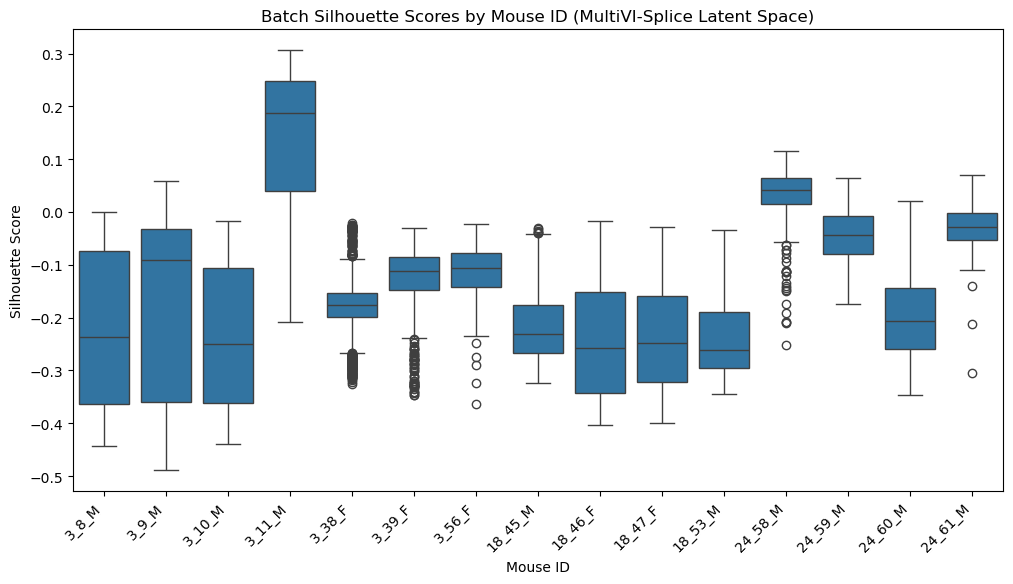

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Batch Silhouette'] = batch_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='mouse.id', y='Batch Silhouette', data=combined_adata.obs)
plt.title('Batch Silhouette Scores by Mouse ID (MultiVI-Splice Latent Space)')
plt.xlabel('Mouse ID')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


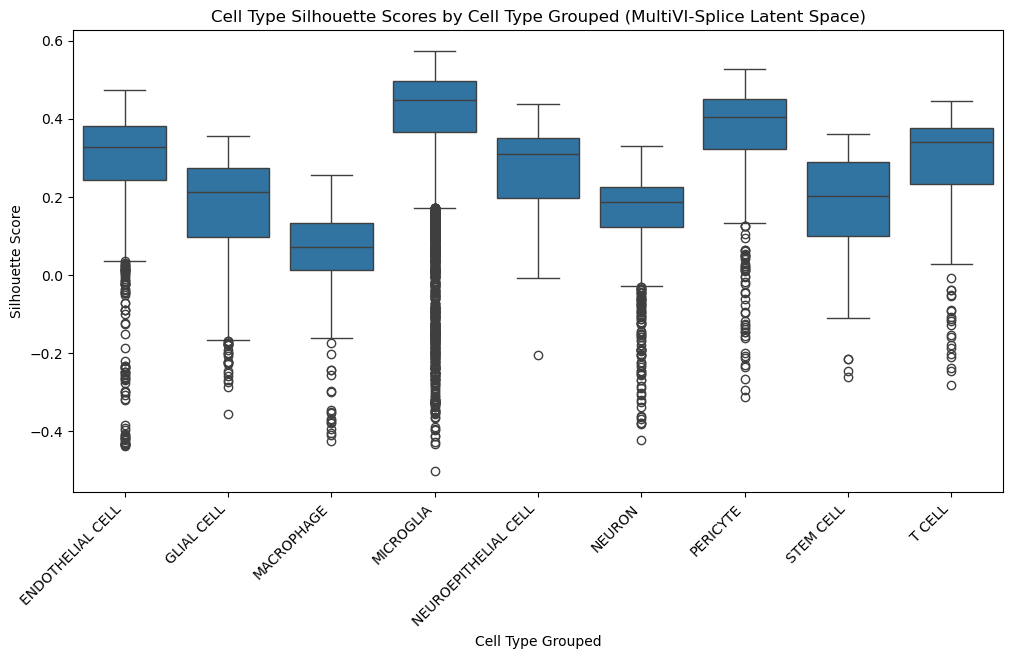

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Cell Type Silhouette'] = cell_type_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='cell_type_grouped', y='Cell Type Silhouette', data=combined_adata.obs)
plt.title('Cell Type Silhouette Scores by Cell Type Grouped (MultiVI-Splice Latent Space)')
plt.xlabel('Cell Type Grouped')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


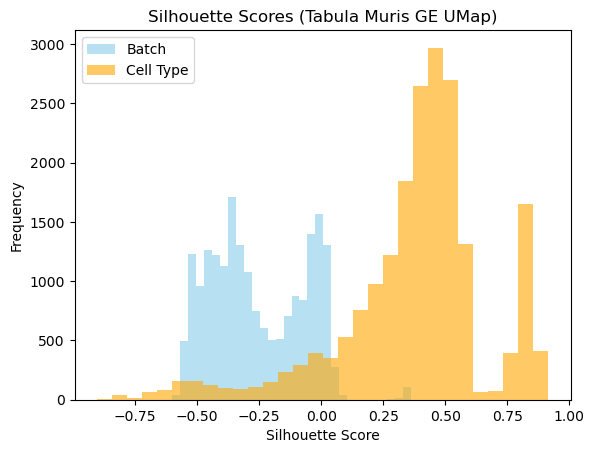

In [16]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd


latent_space = combined_adata.obsm['GE_X_umap']

# batch silhouette
batch_labels = combined_adata.obs['mouse.id']
batch_silhouette = silhouette_samples(latent_space, batch_labels)

# cell type silhouette
cell_type_labels = combined_adata.obs['cell_type_grouped']
cell_type_silhouette = silhouette_samples(latent_space, cell_type_labels)

silhouette_df = pd.DataFrame({
    'Batch Silhouette': batch_silhouette,
    'Cell Type Silhouette': cell_type_silhouette
}, index=combined_adata.obs.index)

import matplotlib.pyplot as plt

plt.hist(silhouette_df['Batch Silhouette'], bins=30, alpha=0.6, label="Batch", color="skyblue")
plt.hist(silhouette_df['Cell Type Silhouette'], bins=30, alpha=0.6, label="Cell Type", color="orange")
plt.legend()
plt.title("Silhouette Scores (Tabula Muris GE UMap)")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.show()


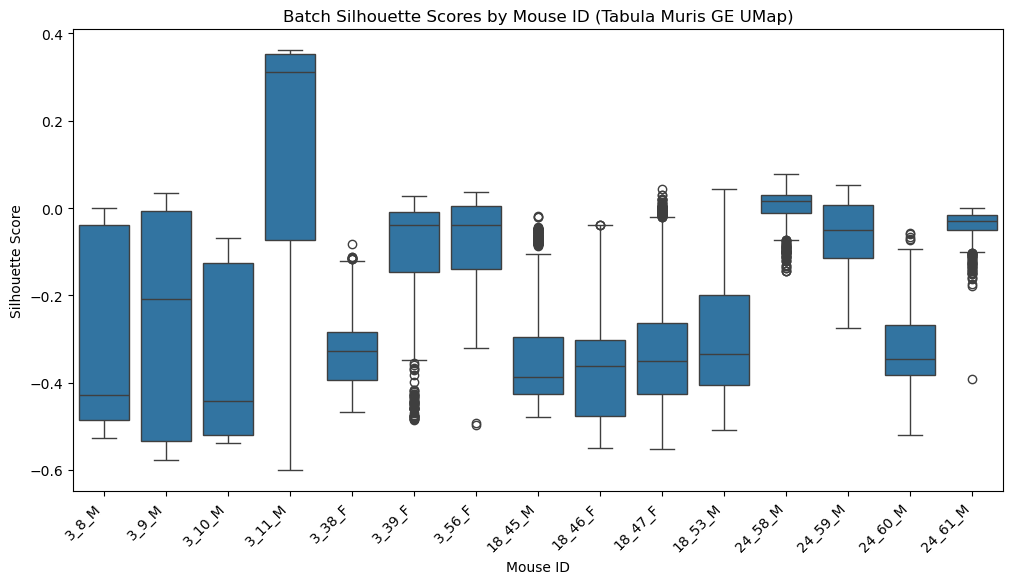

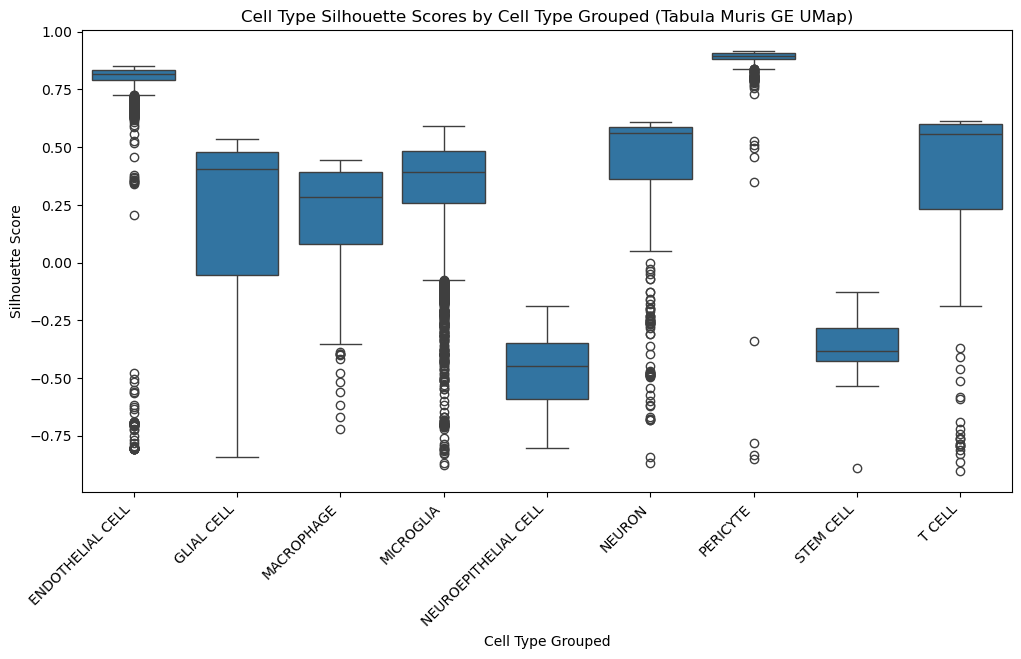

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Batch Silhouette_GE'] = batch_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='mouse.id', y='Batch Silhouette_GE', data=combined_adata.obs)
plt.title('Batch Silhouette Scores by Mouse ID (Tabula Muris GE UMap)')
plt.xlabel('Mouse ID')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Cell Type Silhouette_GE'] = cell_type_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='cell_type_grouped', y='Cell Type Silhouette_GE', data=combined_adata.obs)
plt.title('Cell Type Silhouette Scores by Cell Type Grouped (Tabula Muris GE UMap)')
plt.xlabel('Cell Type Grouped')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()
